# Overall workflow and training

Data generation/training can be performed by built-in executable `lasdi`. For this example of Burgers 1D equation, you can simply run on command-line terminal:
```
lasdi burgers1d.yml
```

The workflow can be also manually constructed for those who prefer python scripts and for prototyping. Following code snippets show the high-level view of the workflow in the executable `lasdi`.

19:16:07.694 - Initialize:Initialize_Trainer:88 - INFO - Initializing Trainer (gplasdi)
19:16:07.694 - Initialize:Initialize_Trainer:88 - INFO - Initializing Trainer (gplasdi)
19:16:07.695 - ParameterSpace:__init__:174 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
19:16:07.695 - ParameterSpace:__init__:174 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
19:16:07.695 - ParameterSpace:__init__:182 - INFO - The training set has 4 parameter combinations
19:16:07.695 - ParameterSpace:__init__:182 - INFO - The training set has 4 parameter combinations
19:16:07.696 - ParameterSpace:__init__:190 - INFO - The testing set has 25 parameter combinations
19:16:07.696 - ParameterSpace:__init__:190 - INFO - The testing set has 25 parameter combinations
19:16:07.696 - Initialize:Initialize_Physics:226 - INFO - Initializing Physics (burgers1d)
19:16:07.696 - Initialize:Initialize_Physics:226 - INFO - Initializing Physics (burgers1d)
19:16:07.697 - Ini

Plotting testing parameter combination number 8 (['a', 'w'] = [0.75 1.05])


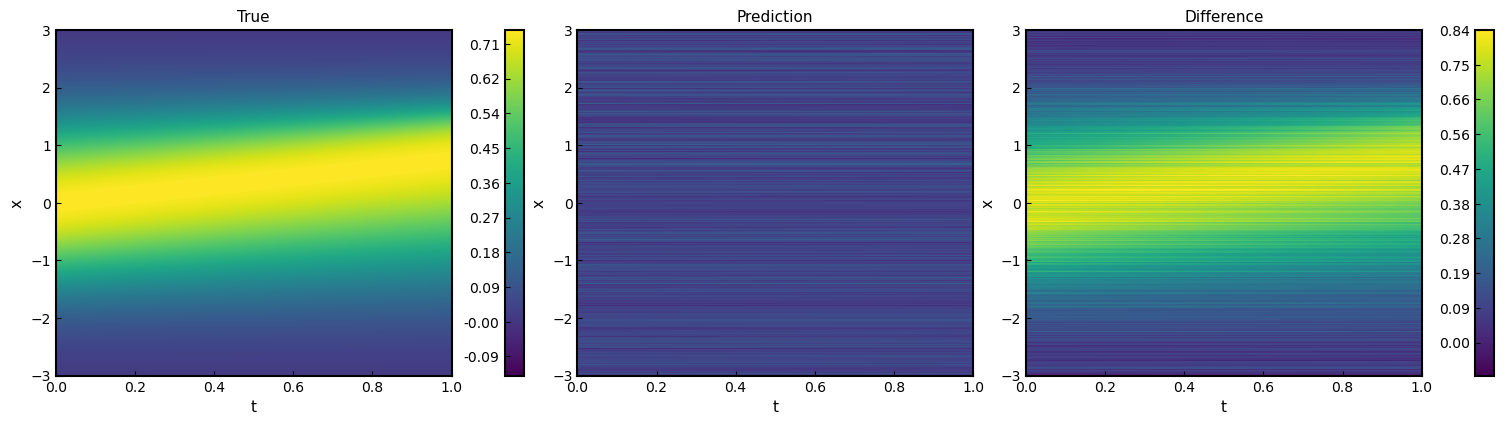

19:16:16.690 - GPLaSDI:train:246 - INFO - Training for 4000 epochs (starting at 0, going to 4000) with 4 parameters
19:16:16.690 - GPLaSDI:train:246 - INFO - Training for 4000 epochs (starting at 0, going to 4000) with 4 parameters
19:16:16.733 - GPLaSDI:train:433 - INFO - Iter: 00001/4000, Total: 0.2130580544, Recon: 0.1927445978, LD: 0.0000070928, Coef: 81.2396545410, max|c|: 28.7, 
19:16:16.733 - GPLaSDI:train:433 - INFO - Iter: 00001/4000, Total: 0.2130580544, Recon: 0.1927445978, LD: 0.0000070928, Coef: 81.2396545410, max|c|: 28.7, 
19:16:16.750 - GPLaSDI:train:433 - INFO - Iter: 00002/4000, Total: 0.2152355760, Recon: 0.2034123093, LD: 0.0000014025, Coef: 47.2902717590, max|c|: 12.6, 
19:16:16.750 - GPLaSDI:train:433 - INFO - Iter: 00002/4000, Total: 0.2152355760, Recon: 0.2034123093, LD: 0.0000014025, Coef: 47.2902717590, max|c|: 12.6, 
19:16:16.764 - GPLaSDI:train:433 - INFO - Iter: 00003/4000, Total: 0.2044143975, Recon: 0.1959584355, LD: 0.0000022904, Coef: 33.8192787170, max

Function name	Calls	Total time	Time/call

train_step	4000	4.918e+01	1.230e-02

finalize	1	1.911e-03	1.911e-03



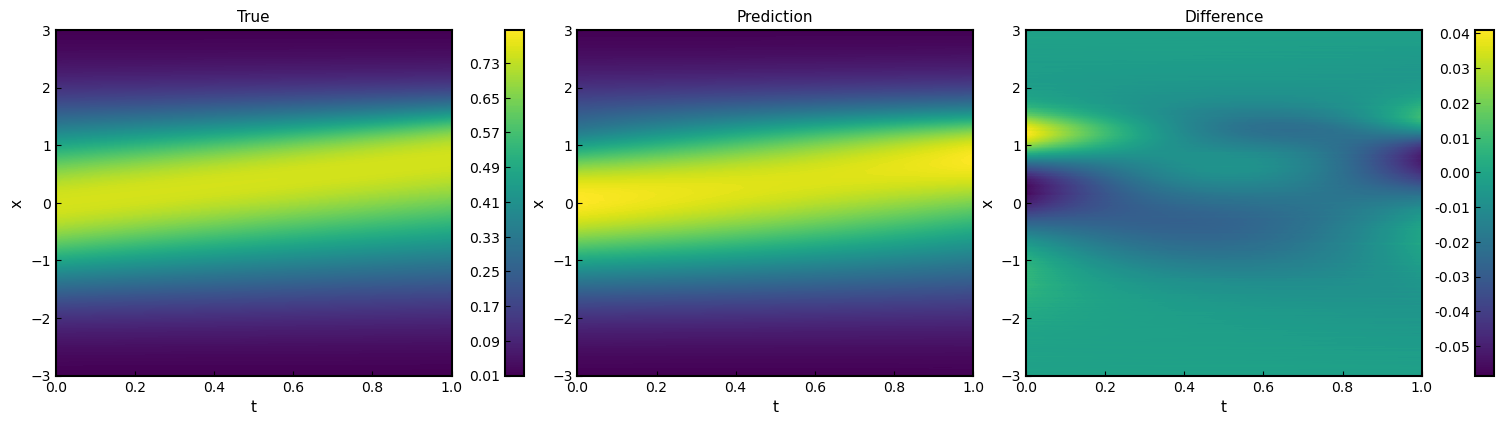

In [1]:
# -------------------------------------------------------------------------------------------------
# Imports 
# -------------------------------------------------------------------------------------------------

import  os;
import  sys;

src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
utils_path  : str = os.path.join(src_path, "Utilities");
sys.path.append(src_path);
sys.path.append(utils_path);

import  random;
import  yaml;
import  logging;

import  torch
import  numpy;

from    Workflow    import  Save;
from    Enums       import  NextStep, Result
from    Sample      import  Run_Samples, Pick_Samples;
from    Initialize  import  Initialize_Trainer;
from    Logging     import  Initialize_Logger, Log_Dictionary;
from    Plot        import  Plot_Reconstruction;


# -------------------------------------------------------------------------------------------------
# Setup
# -------------------------------------------------------------------------------------------------

# Set up the logger
Initialize_Logger(logging.INFO);
LOGGER  : logging.Logger    = logging.getLogger(__name__);

# Load the configuration.
cfg_file : str = 'burgers1d.yml';
with open(cfg_file, 'r') as f:
    config : dict = yaml.safe_load(f);
Log_Dictionary(LOGGER = LOGGER, D = config, level = logging.DEBUG);

# Setup the trainer
trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config);



# -------------------------------------------------------------------------------------------------
# Train
# -------------------------------------------------------------------------------------------------

LOGGER.info("Training with %d epochs" % trainer.max_iter);

# generate initial training/test data
Pick_Samples(trainer, config);
Run_Samples(trainer, config);



# Fetch the number of testing, training examples.
n_train : int   = param_space.train_space.shape[0];
n_test  : int   = param_space.test_space.shape[0];
n_IC    : int   = latent_dynamics.n_IC;

# Select a random parameter combination to investigate.
index_plot  : int = random.randrange(0, n_test);
print("Plotting testing parameter combination number %d (%s = %s)" % (index_plot, str(param_space.param_names), str(param_space.test_space[index_plot, :])));

# Select the testing data corresponding to the specified parameter combination
Plot_Reconstruction(
        X_True  = [trainer.X_Test[d][index_plot, ...] for d in range(n_IC)], 
        model   = trainer.model, 
        t_grid  = trainer.physics.t_grid, 
        x_grid  = trainer.physics.x_grid);

# initial training given training data
trainer.train();

Plot_Reconstruction(
        X_True  = [trainer.X_Test[d][index_plot, ...] for d in range(n_IC)], 
        model   = trainer.model, 
        t_grid  = trainer.physics.t_grid, 
        x_grid  = trainer.physics.x_grid);

while (trainer.restart_iter < trainer.max_iter):
    if (trainer.restart_iter <= trainer.max_greedy_iter):
        # perform greedy sampling to pick up new samples
        Pick_Samples(trainer, config);
        # update training data with newly picked samples
        Run_Samples(trainer, config);

    # train over given training data
    trainer.train();

    # Plot 
    Plot_Reconstruction(  
            X_True  = [trainer.X_Test[d][index_plot, ...] for d in range(n_IC)], 
            model   = trainer.model, 
            t_grid  = trainer.physics.t_grid, 
            x_grid  = trainer.physics.x_grid);

# Finally, save!
Save(   param_space         = param_space, 
        physics             = physics, 
        model               = model, 
        latent_dynamics     = latent_dynamics, 
        trainer             = trainer, 
        next_step           = NextStep.PickSample, 
        result              = Result.Success,
        restart_filename    = None);

If you ran the command instead, a restart file is saved at the end of the training, which can be loaded for post-processing:

In [ ]:
# Add src directory to the search path
import  os;
import  sys;
src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
sys.path.append(src_path);

import  yaml
from    ParameterSpace  import  ParameterSpace;
from    Initialize      import  Initialize_Trainer;

# Specify the restart file you have.
filename = 'lasdi_10_01_2024_17_09.npy'

cfg_file = 'burgers1d.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

restart_file = numpy.load(filename, allow_pickle = True).item()

trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config, restart_file)

# Post-processing

Setup data for post-processing:

In [2]:
n_coef              : int                   = latent_dynamics.n_coefs;
n_IC                : int                   = latent_dynamics.n_IC; 
n_p                 : int                   = param_space.n_p; 

coefs               : numpy.ndarray         = trainer.best_coefs;           # shape = (n_train, n_coefs).
X_Train             : list[torch.Tensor]    = trainer.X_Train;              # len = n_IC. d'th element has shape (n_train, n_t, n_x), holds d'th derivative of fom train solutions
X_Test              : list[torch.Tensor]    = trainer.X_Test;               # len = n_IC. d'th element has shape (n_train, n_t, n_x), holds d'th derivative of fom test solutions.

param_train         : numpy.ndarray         = param_space.train_space;      # shape = (n_test, n_p)
param_test          : numpy.ndarray         = param_space.test_space;       # shape = (n_test, n_p)
param_names         : list[str]             = param_space.param_names;

test_meshgrid       : tuple[numpy.ndarray]  = param_space.test_meshgrid;    # len = n_p. i'th element is meshgrid for i'th parameter.
test_grid_sizes     : list[int]             = param_space.test_grid_sizes;  # len = n_p. i'th element holds the number of values of the i'th parameter in the test set.
n_init_train        : int                   = param_space.n_init_train;     # The initial number of combinations of parameters in the training set.
n_test              : int                   = param_test.shape[0];
n_train             : int                   = param_train.shape[0];

t_grid              : numpy.ndarray         = physics.t_grid;               # set of t values at which we evaluate the fom solution
x_grid              : numpy.ndarray         = physics.x_grid;               # set of x values at which we evaluate the fom solution.
t_mesh, x_mesh                              = numpy.meshgrid(t_grid, x_grid);

# Fetch information about the temporal, spatial grids.
Dt                  : float                 = physics.dt
Dx                  : float                 = physics.dx;
n_t                 : int                   = t_grid.shape[0];
n_x                 : int                   = x_grid.shape[0];


They can be also loaded directly from restart file:

In [ ]:
n_coef              : int                   = restart_file['latent_dynamics']['n_coefs'];
n_IC                : int                   = restart_file['latent_dynamics']['n_IC'];
n_p                 : int                   = restart_file['parameter_space']['n_p'];

coefs               : numpy.ndarray         = restart_file['trainer']['best_coefs'];    # shape = (n_train, n_coefs); np = number of combinations of parameters
X_Train             : list[torch.Tensor]    = restart_file['trainer']['X_Train'];       # len = n_IC. i'th element has shape (n_train, n_t, ...), holds d'th derivative of fom test solutions.
X_Test              : list[torch.Tensor]    = restart_file['trainer']['X_Test'];        # len = n_IC. i'th element has shape (n_test, n_t, ...), holds d'th derivative of fom test solutions.

paramspace_dict     : dict                  = restart_file['parameter_space'];          # parameter space save dictionary.
param_train         : numpy.ndarray         = paramspace_dict['train_space'];           # shape = (n_train, n_p)
param_test          : numpy.ndarray         = paramspace_dict['test_space'];            # shape = (n_test, n_p)
param_names         : list[str]             = param_space.param_names;

test_meshgrid       : list[int]             = paramspace_dict['test_meshgrid'];         # len = n_p. i'th element is meshgrid for i'th parameter.
test_grid_sizes     : list[int]             = paramspace_dict['test_grid_sizes'];       # len = n_p. i'th element holds the number of values of the i'th parameter in the test set.
n_init_train        : int                   = paramspace_dict['n_init'];                # The initial number of combinations of parameters in the training set.
n_test              : int                   = param_test.shape[0];
n_train             : int                   = param_train.shape[0];

physics_dict        : dict                  = restart_file['physics'];                  
t_grid              : numpy.ndarray         = physics_dict['t_grid'];                   # set of t values at which we evaluate the fom solution
x_grid              : numpy.ndarray         = physics_dict['x_grid'];                   # set of x values at which we evaluate the fom solution.
t_mesh, x_mesh                              = numpy.meshgrid(t_grid, x_grid);

# Fetch information about the temporal, spatial grids.
Dt                  : float                 = physics.dt
Dx                  : float                 = physics.dx;
n_t                 : int                   = t_grid.shape[0];
n_x                 : int                   = x_grid.shape[0];

## Gaussian-process uncertainty evaluation
For each combination of parameters, evaluate the coefficient GPs to generate a set of coefficients for the latent dynamics for that parameter combination. Then solve each latent dynamics forward in time.

In [3]:
# First, we need to import a few new things.
import os;
import sys;
physics_path : str = os.path.join(os.path.join(os.path.pardir, "src"), "Physics");
sys.path.append(physics_path);

from    sklearn.gaussian_process    import  GaussianProcessRegressor;

import  Simulate;
import  GaussianProcess;
from    Physics                     import  Physics;
from    Model                       import  Autoencoder, Autoencoder_Pair;

# Setup
n_samples : int = 20;
model.cpu();



# Get a GP for each coefficient in the latent dynamics.
gp_list         : list[GaussianProcessRegressor]    = GaussianProcess.fit_gps(param_space.train_space, coefs);

Zis_samples     : list[numpy.ndarray]   = Simulate.sample_roms(model, physics, latent_dynamics, gp_list, param_test, n_samples); # n_IC elements. Each has shape (n_test, n_samples, n_t, n_z)
Zis_mean        : list[numpy.ndarray]   = Simulate.average_rom(model, physics, latent_dynamics, gp_list, param_test);            # n_IC elements. Each has shape (n_test, n_t, n_z).


/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Now, decode the latent trajectories and compare them to the test set. Use these values to compute some errors. 

In [4]:
# Pass the samples through the decoder. The way this works depends on what kind of model we are using. 
if(isinstance(model, Autoencoder)):
    # Decode the mean predictions.
    X_pred_mean     : list[numpy.ndarray]   = [model.Decode(torch.Tensor(Zis_mean[0])).detach().numpy()];  # shape = (n_test, n_t, n_x)

    # Decode the Zis for each parameter. Note that the decoder expects a 3d tensor of shape 
    # (n_test, n_t, n_z). We can somewhat abuse this by treating the different samples as different 
    # parameters. We still need to loop over the number of parameters, however.
    X_pred_samples  : list[numpy.ndarray]   = [numpy.empty((n_test, n_samples, n_t, n_x))];
    for i in range(n_test):
        X_pred_samples[0][i, :, : , :]  = model.Decode(torch.Tensor(Zis_samples[0][i, :, :, :])).detach().numpy();

elif(isinstance(model, Autoencoder_Pair)):
    # Decode the mean predictions.
    Disp_Pred_mean, Vel_Pred_mean           = model.Decode(torch.Tensor(Zis_mean[0]), torch.Tensor(Zis_mean[1]));
    X_pred_mean     : list[numpy.ndarray]   = [Disp_Pred_mean.detach().numpy(), Vel_Pred_mean.detach().numpy()];

    # Decode the Zis for each parameter. Note that the decoder expects a 3d tensor of shape 
    # (n_test, n_t, n_z). We can somewhat abuse this by treating the different samples as different 
    # parameters. We still need to loop over the number of parameters, however.
    X_pred_samples  : list[numpy.ndarray]   = [numpy.empty((n_test, n_samples, n_t, n_x)), numpy.empty((n_test, n_samples, n_t, n_x))];
    for i in range(n_test):
        ith_Disp_Pred, ith_Vel_Pred     = model.Decode(torch.Tensor(Zis_samples[0][i, :, :, :]), torch.Tensor(Zis_samples[1][i, :, :, :]));
        X_pred_samples[0][i, :, :, :]   = ith_Disp_Pred.detach().numpy();
        X_pred_samples[1][i, :, :, :]   = ith_Vel_Pred.detach().numpy();



# Set up arrays to hold the average error between X_pred_mean and X_test, as well as the std of 
# the predictions.
mean_rel_error   : list[numpy.ndarray]   = [];
max_std          : list[numpy.ndarray]   = [];
for d in range(n_IC):
    mean_rel_error.append(  numpy.zeros(n_test, dtype = numpy.float32));
    max_std.append(         numpy.zeros(n_test, dtype = numpy.float32));

# For each d \in {0, 1, ... , n_IC - 1} and k \in { 1, 2, ... , n_test - 1}, find the std of the 
# frame of the d'th derivative of the fom solution with the k'th combination of parameter values 
# that has the greatest variance + find the mean error between X_Pred_mean[d][k, ...] and 
# X_test[d][k, ...].
for d in range(n_IC):
    for k in range(n_test):        
        # Extract the prediction, true values for the d'th component of the fom solution when we use 
        # the k'th parameter value. These have shape (n_t, n_x).
        kth_X_Pred_d            : numpy.ndarray = X_pred_mean[d][k, :, :];
        kth_X_Test_d            : numpy.ndarray = X_Test[d][k, :, :].numpy();
        
        # For each compute the relative error between the predicted and true values of the d'th 
        # derivative of the fom solution at each time step when we use the k'th combination of 
        # parameter values.
        kth_Relative_Errors_d   : numpy.ndarray = numpy.linalg.norm(kth_X_Pred_d - kth_X_Test_d, axis = 1) / numpy.linalg.norm(kth_X_Test_d, axis = 1);
        mean_rel_error[d][k]                    = kth_Relative_Errors_d.max();

        # Finally, compute the std of the frames of the prediction for the d'th derivative of the 
        # fom solution when we use the k'th combination of parameter values.
        max_std[d][k]           = X_pred_samples[d][k, :, :].std(0).max();



# Get the mean and std of each coefficient's distribution when we evaluate the posterior coefficient 
# distributions at each testing parameter value. We then reshape these arrays to have shape 
# (N(1), ... , N(n_p)), where N(k) is the number of distinct values of the k'th parameter in the 
# training set. The i(1), ... , i(n_p), j element of the d'th element of these lists will hold the 
# mean and std of the distribution of the j'th parameter when we use the i(k)'th value of the k'th 
# parameter.
gp_pred_mean, gp_pred_std = GaussianProcess.eval_gp(gp_list, param_test);
gp_pred_mean    = gp_pred_mean.reshape(test_grid_sizes + [-1]);
gp_pred_std     = gp_pred_std.reshape(test_grid_sizes + [-1]);

# Reshape each element of mean_rel_error and max_std has shape (N(1), ... , N(n_p)), where N(k) 
# is the number of distinct values of the k'th parameter in the training set. The i(1), ... , i(n_p) 
# element of the d'th element of these lists will hold the mean error and std of the prediction of 
# the d'th derivative of the fom solution when we use the i(k)'th value of the k'th parameter, 
# respectively.
for d in range(n_IC):
    mean_rel_error[d]   = mean_rel_error[d].reshape(test_grid_sizes);
    max_std[d]          = max_std[d].reshape(test_grid_sizes);

# Visualization

Plot mean and standard deviation of coefficient matrix.
For SINDy of dimension 5, the coefficient matrix has a shape of (6, 5).

19:17:19.417 - Plot:Plot_GP2d:422 - INFO - Producing GP plots with 30 coefficients. The parameters are ['a', 'w']
19:17:19.417 - Plot:Plot_GP2d:422 - INFO - Producing GP plots with 30 coefficients. The parameters are ['a', 'w']


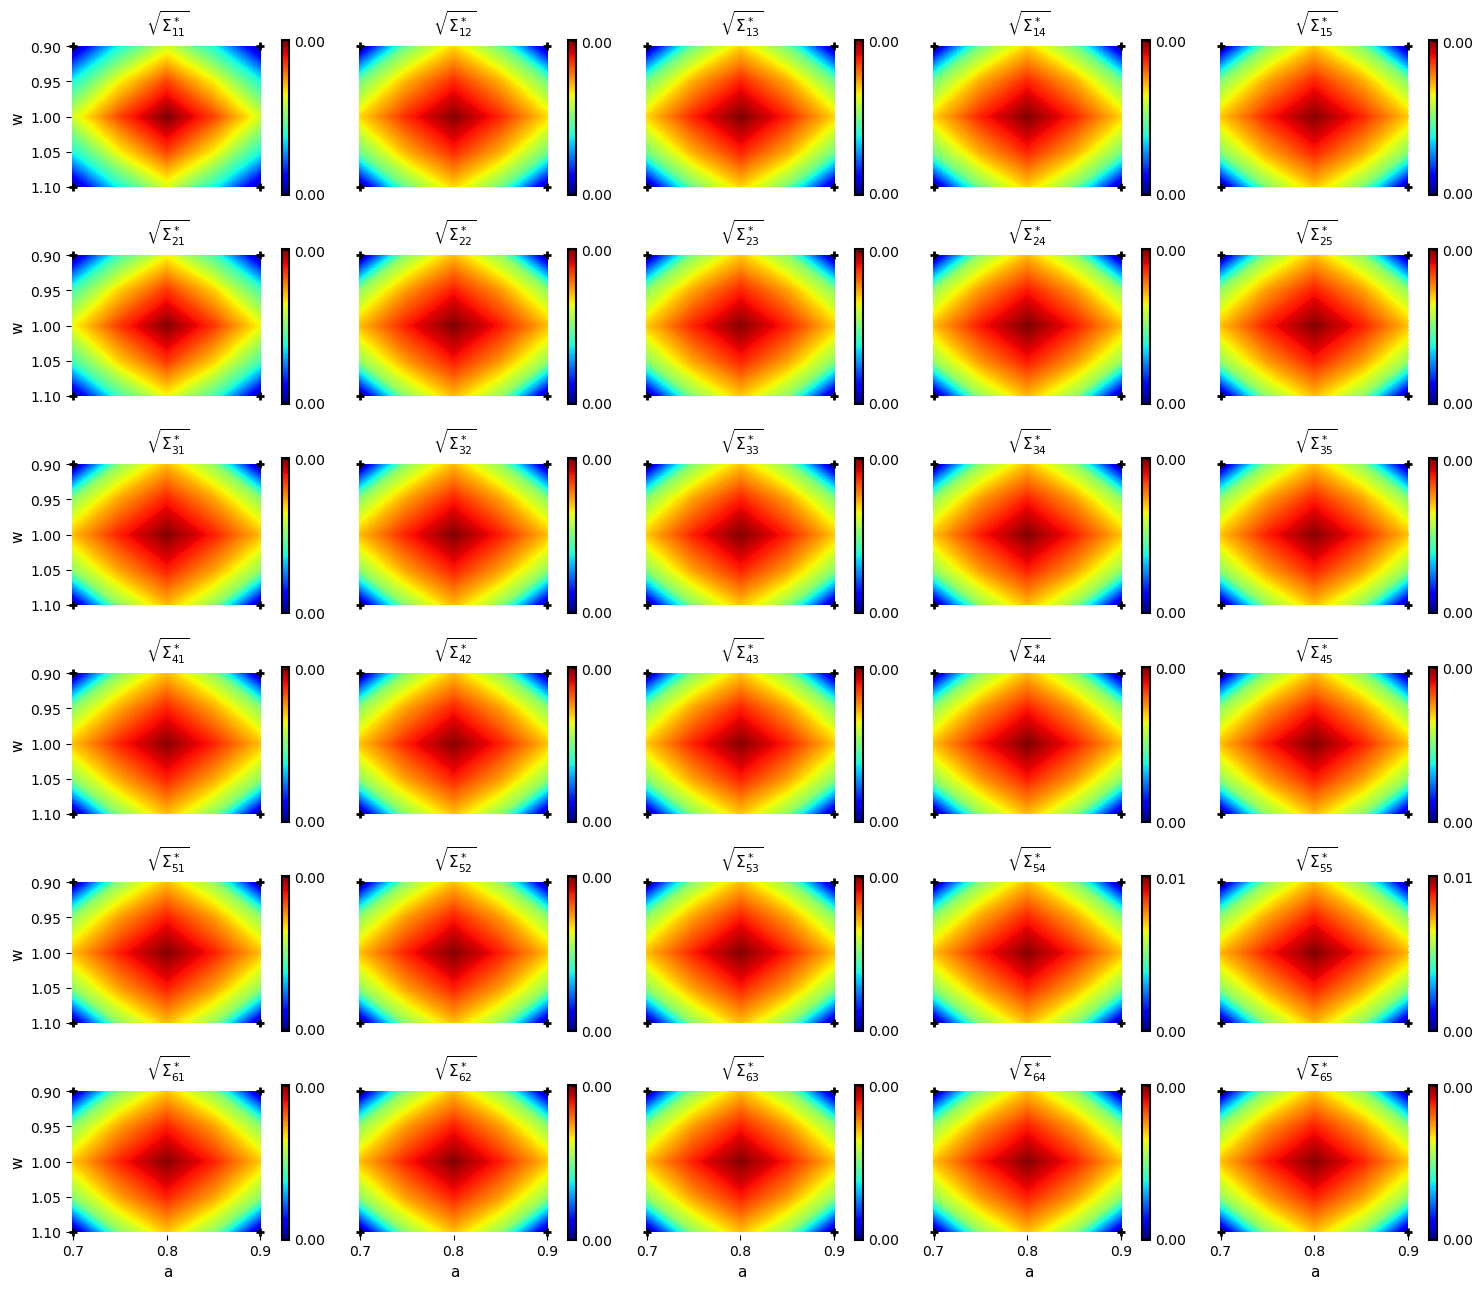

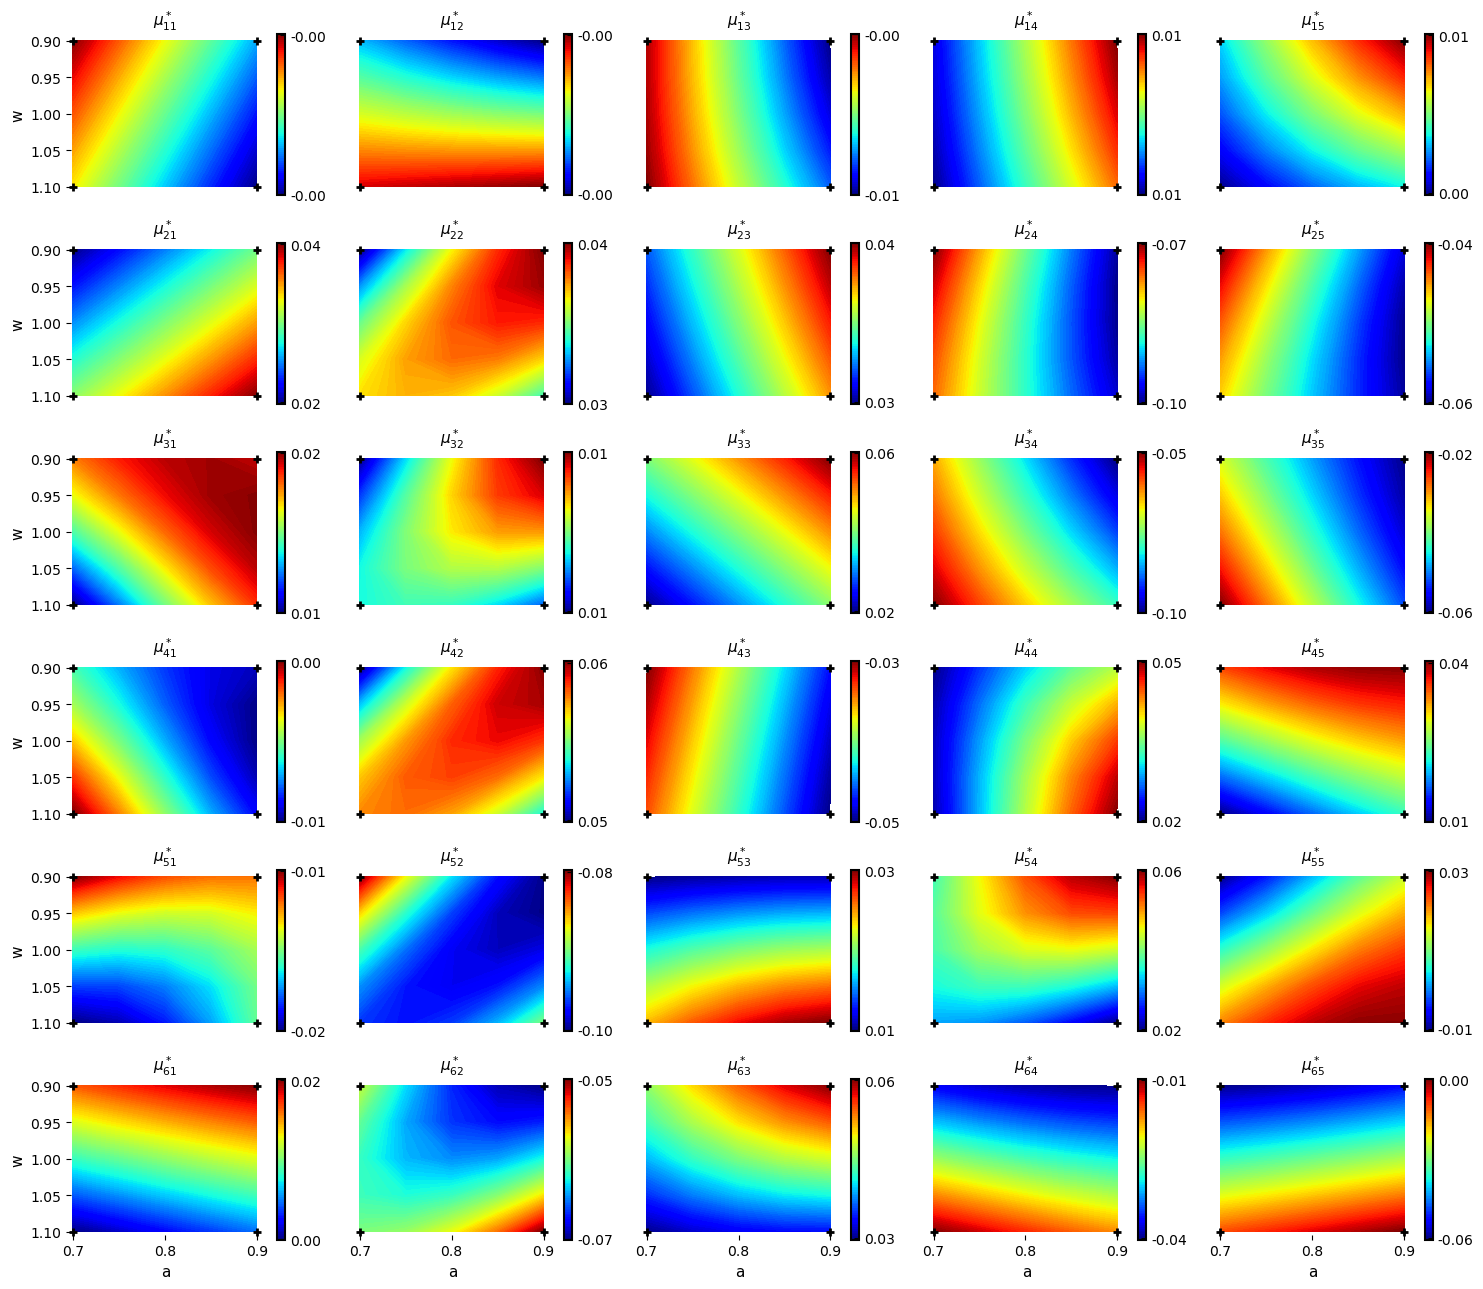

In [5]:
import  Plot;

if(n_p == 2):
    Plot.Plot_GP2d( p1_mesh     = test_meshgrid[0], 
                    p2_mesh     = test_meshgrid[1], 
                    gp_mean     = gp_pred_mean, 
                    gp_std      = gp_pred_std, 
                    param_train = param_train, 
                    param_names = param_names, 
                    n_cols      = 5);

19:17:23.083 - Plot:Plot_Heatmap2d:599 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 4 training points (4 initial) and 25 testing points.
19:17:23.083 - Plot:Plot_Heatmap2d:599 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 4 training points (4 initial) and 25 testing points.


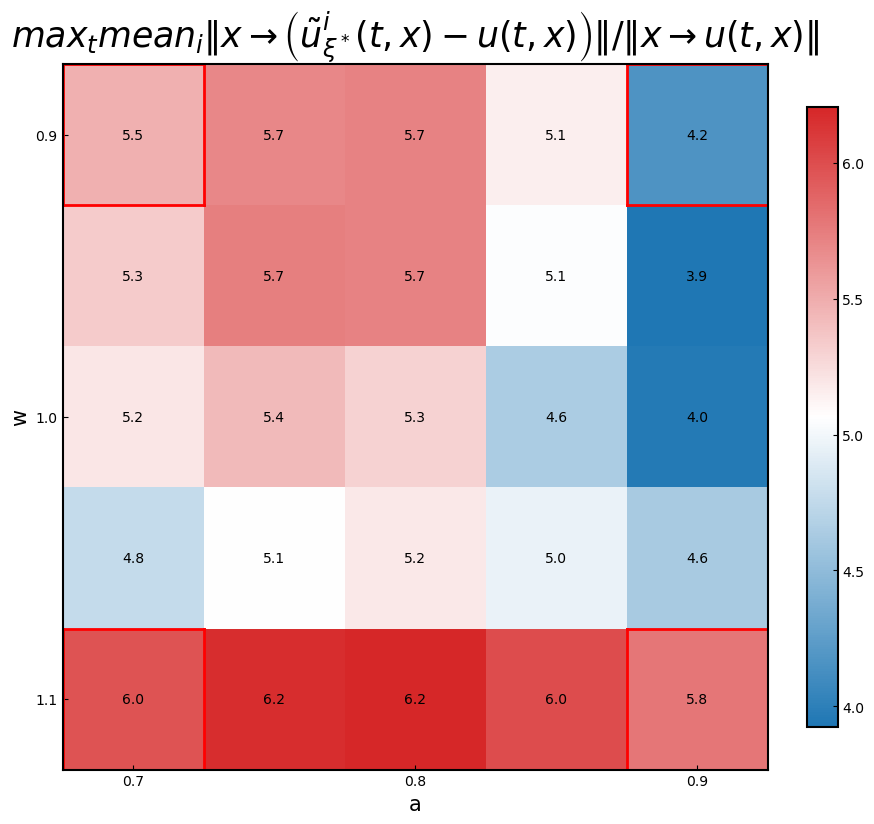

In [6]:
import importlib;
importlib.reload(Plot);

for d in range(n_IC):
    if(d == 0):
        title_string : str = r'$max_{t} mean_{i} \|x \to \left(\tilde{u}_{\xi^*}^{i}(t, x) - u(t, x) \right) \|/\| x \to u(t, x)\|$';
    else:
        title_string : str = r'$max_{t} mean_{i} \left\|x \to \left( \frac{d^{%d}}{dt^{%d}}\tilde{u}_{\xi^*}^{i}(t, x) - \frac{d^{%d}}{dt^{%d}}u(t, x) \right) \right\|$' % (d, d, d, d);


    Plot.Plot_Heatmap2d(values          = mean_rel_error[d] * 100, 
                        p1_grid         = test_meshgrid[0][:, 0], 
                        p2_grid         = test_meshgrid[1][0, :], 
                        param_train     = param_train, 
                        n_init_train    = param_space.n_init_train, 
                        param_names     = param_names, 
                        title           = title_string);

19:17:27.280 - Plot:Plot_Heatmap2d:599 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 4 training points (4 initial) and 25 testing points.
19:17:27.280 - Plot:Plot_Heatmap2d:599 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 4 training points (4 initial) and 25 testing points.


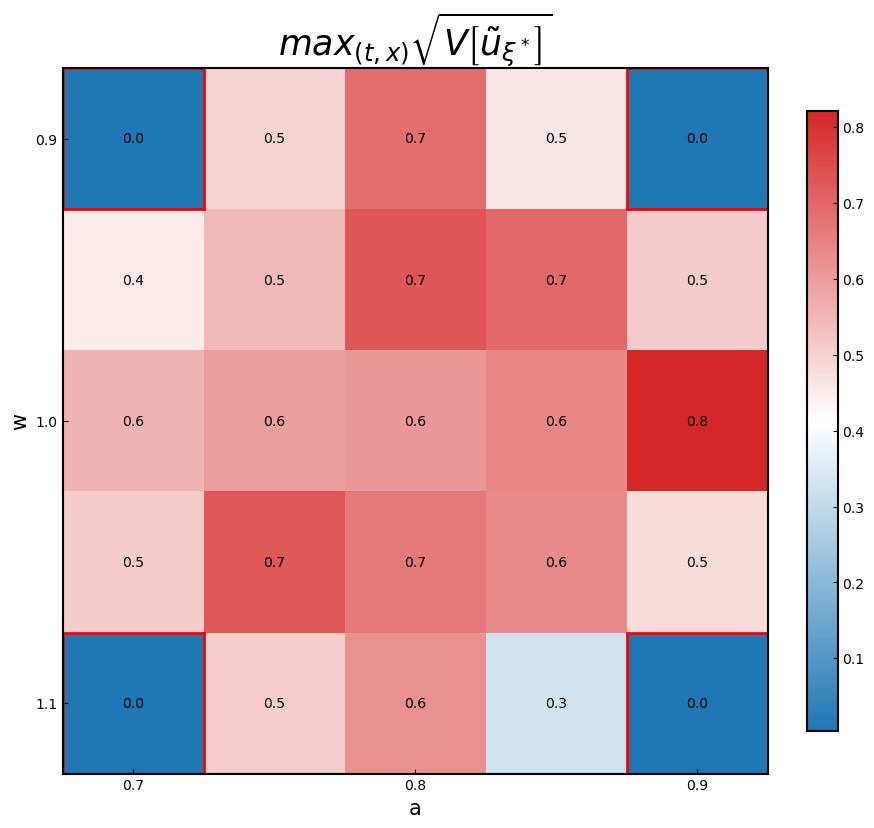

In [7]:
import importlib
importlib.reload(Plot);

for d in range(n_IC):
    if(d == 0):
        title : str = r'$max_{(t, x)} \sqrt{ V \left[ \tilde{u}_{\xi^*} \right] }$';
    else:
        title : str = r'$max_{(t, x)} \sqrt{ V \left[\frac{d^{%d}}{dt^{%d}}\tilde{u}_{\xi^*} \right] }$' % (d, d);


    Plot.Plot_Heatmap2d(values          = max_std[d] * 100, 
                        p1_grid         = test_meshgrid[0][:, 0], 
                        p2_grid         = test_meshgrid[1][0, :], 
                        param_train     = param_train, 
                        n_init_train    = param_space.n_init_train, 
                        param_names     = param_names, 
                        title           = title);

/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
19:17:32.327 - Plot:Plot_Prediction:251 - INFO - Computing mean/std of predictions. The Latent Trajectories have a shape of (n_params, n_samples, n_t, n_z) = (1, 20, 501, 5)
19:17:32.327 - Plot:Plot_Prediction:251 - INFO - Computing mean/std of predictions. The Latent Trajectories have a shape of (n_params, n_samples, n_t, n_z) = (1, 20, 501, 5)


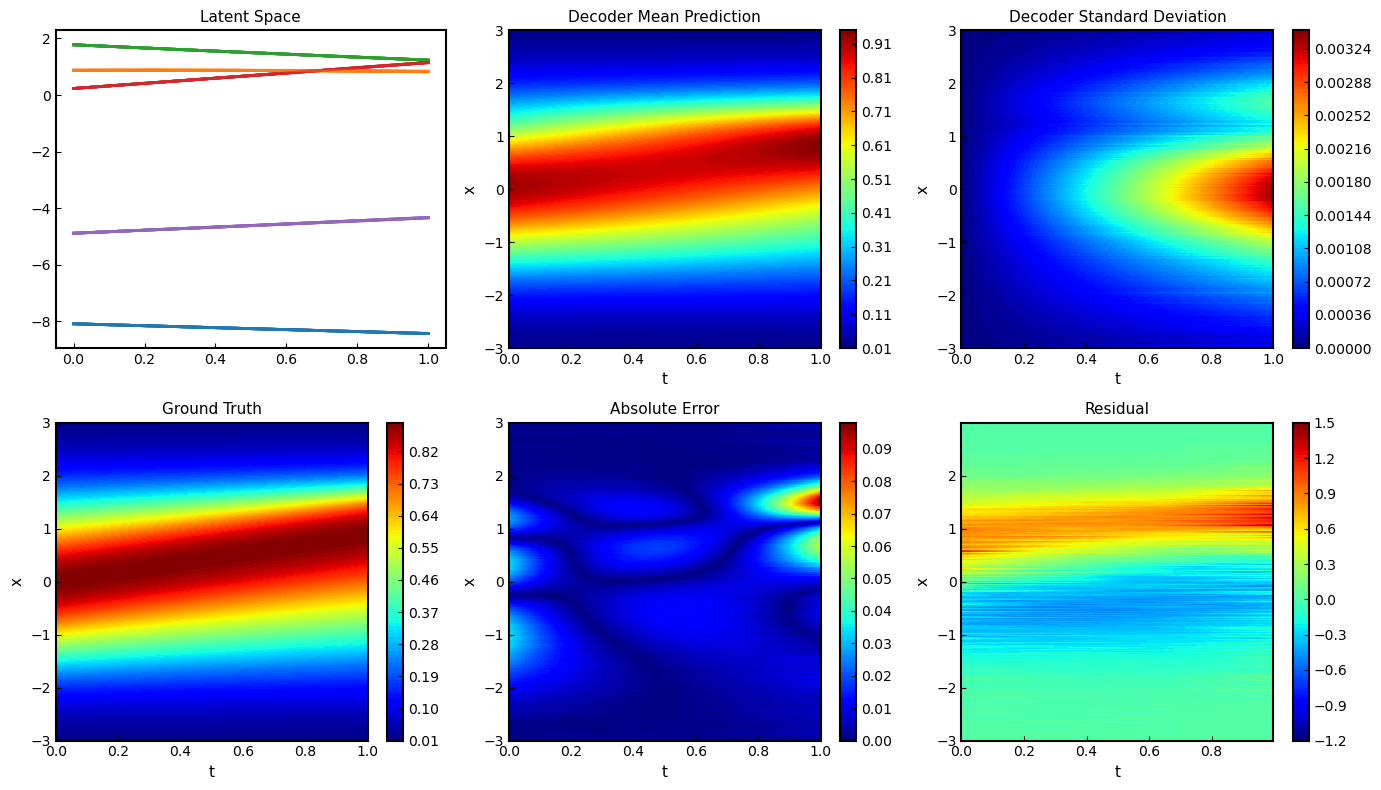

In [8]:
import importlib
importlib.reload(Plot);

# Pick some parameter values.
a           : float                 = 0.9;
w           : float                 = 1.07; 
param_grid  : numpy.ndarray         = numpy.array([[a, w]]);

# Get the predicted solution using this parameter value.
X_True      : list[torch.Tensor]    = physics.solve(param_grid[0]);
for d in range(n_IC):
    X_True[d] = X_True[d].detach().squeeze().numpy();

# Plot the predictions!
Plot.Plot_Prediction(
            model           = model, 
            physics         = physics, 
            latent_dynamics = latent_dynamics, 
            param_grid      = param_grid,
            gp_list         = gp_list, 
            n_samples       = n_samples, 
            X_True          = X_True);
